import numpy as np
import quaternion

T=10
d=np.ones(3)
F_B=d*T
print(F_B.shape)
q=np.quaternion(0,4/5,0,3/5)

def vec2quat(vec):
    return np.quaternion(0,vec[0],vec[1],vec[2])
def quat23dvec(quat):
    return np.array([quat.x,quat.y,quat.z])
def cross_operator(x): #assuming x is shape (1,dim)
    ret=np.zeros((x.shape[0],x.shape[0]))
    for t in range(x.shape[0]):
        ret[t][t]=x[t]
    return ret
def quat24dvec(x):
    return np.array([x.w,x.x,x.y,x.z])
def omegaOperator(x):
    return np.array([
                     [0,-x[0],-x[1],-x[2]],
                     [x[0],0,x[2],-x[1]],
                     [x[1],-x[2],0,x[0]],
                     [x[2],x[1],-x[0],0]])

F_N=quat23dvec(q*vec2quat(F_B)*q.conjugate())
r=np.ones(3)
L_B=np.cross(r,F_B)
L_B

cross_operator(np.array([1,2,3]))

J=np.array([[2,0,0],[0,3,0],[0,0,4]])

J_inv=np.linalg.inv(J)
w=np.array([1,2,4])
w_dot=-J_inv@cross_operator(w)@J@w+J_inv@L_B

q_dot=vec2quat(w)*q/2
print(q_dot)
q_dot=quat24dvec(q_dot)

q_dot

In [25]:
import numpy as np
import sys
from casadi import *
import matplotlib.pyplot as plt

# Import do_mpc package:
import do_mpc
T=10
r=np.array([0,0,-1])

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
r=model.set_variable('_x','linear',(3))
v=model.set_variable('_x','dlinear',(3))
m=model.set_variable('_x','mass',(1))
q=model.set_variable('_x','attitude',(4))
omega=model.set_variable('_x','omega',(3))
g=np.array([0,0,-9.81])
d=model.set_variable('_u','tvc',(3))
# L_B=model.set_variable('_z','torque',(3))
# F_N=model.set_variable('_z','force',(3))
# J=model.set_variable('_z','Inertia',(3,3))
# omega_crap=model.set_variable('_z','omegacrap',(3,3))
# omega_ham=model.set_variable('_z','omegaham',(4,4))

In [4]:
F_B=d*T

In [5]:
F_N=SX.sym('force_in',3)

In [6]:
x,y,z=vertsplit(F_B)
qw,qx,qy,qz=vertsplit(q)
print(qw)
F_N[0] = x*(qx*qx+qw*qw-qy*qy- qz*qz) + y*(2*qx*qy- 2*qw*qz) + z*(2*qx*qz+ 2*qw*qy)
F_N[1] = x*(2*qw*qz + 2*qx*qy) + y*(qw*qw - qx*qx+ qy*qy - qz*qz)+ z*(-2*qw*qx+ 2*qy*qz)
F_N[2] = x*(-2*qw*qy+ 2*qx*qz) + y*(2*qw*qx+ 2*qy*qz)+ z*(qw*qw - qx*qx- qy*qy+ qz*qz)

attitude_0


In [7]:
J=SX.sym('moi',3,3)
J[0,0]=10
J[0,1]=0
J[0,2]=0
J[1,0]=0
J[1,1]=10
J[1,2]=0
J[2,0]=0
J[2,1]=0
J[2,2]=10

In [8]:
op=SX.sym('op',3,3)
op[0,0]=0
op[0,1]=-omega[2]
op[0,2]=omega[1]
op[1,0]=omega[2]
op[1,1]=0
op[1,2]=-omega[0]
op[2,0]=-omega[1]
op[2,1]=omega[0]
op[2,2]=0

In [9]:
L_B=cross(r,F_B)

In [10]:
oh=SX.sym('oh',4,4)
oh[0,0]=0
oh[0,1]=-omega[0]
oh[0,2]=-omega[1]
oh[0,3]=-omega[2]
oh[1,0]=omega[0]
oh[1,1]=0
oh[1,2]=omega[2]
oh[1,3]=-omega[1]
oh[2,0]=omega[1]
oh[2,1]=-omega[2]
oh[2,2]=0
oh[2,3]=omega[0]
oh[3,0]=omega[2]
oh[3,1]=omega[1]
oh[3,2]=-omega[0]
oh[3,3]=0
oh

SX(@1=0, 
[[@1, (-omega_0), (-omega_1), (-omega_2)], 
 [omega_0, @1, omega_2, (-omega_1)], 
 [omega_1, (-omega_2), @1, omega_0], 
 [omega_2, omega_1, (-omega_0), @1]])

In [11]:
J_inv=inv(J)
domega=-J_inv@op@J@omega+L_B
dq=(oh@q)/2
print(domega.shape)

(3, 1)


In [12]:
dv=(F_N/m)+g

In [13]:
dm=(sqrt(F_B[0]**2+F_B[1]**2+F_B[2]**2))/100 # 100 is I_sp*g_ref

In [14]:
model.set_rhs('attitude',dq)
model.set_rhs('omega',domega)
model.set_rhs('dlinear',dv)
model.set_rhs('linear',v)
model.set_rhs('mass',dm)

In [15]:
model.setup()

In [16]:
mpc = do_mpc.controller.MPC(model)

In [17]:
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 1,
    'open_loop': 0,
    't_step': 0.005,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

In [18]:
_x = model.x
mterm = (_x['linear'][0] - 0.6)**2 # terminal cost
lterm = (_x['omega'][0] - 0.6)**2 # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

In [19]:
mpc.setup()

/home/parth/.local/lib/python3.9/site-packages/do_mpc/controller.py:904: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [20]:
simulator = do_mpc.simulator.Simulator(model)

In [21]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.005
}

simulator.set_param(**params_simulator)
simulator.setup()

In [22]:
estimator = do_mpc.estimator.StateFeedback(model)

In [37]:
x0=np.array([0,0,0,0,0,0,10,0,0,0,1,0,0,0]).reshape(-1,1)
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
print(x0)
mpc.set_initial_guess()

[[ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [10]
 [ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 0]
 [ 0]
 [ 0]]


In [40]:
data=[]
time=[]
for k in range(50):
    u0=mpc.make_step(x0)
    u0=np.array([[0],[0],[1]])
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    data.append(x0[0])
    time.append(k)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10814
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4221

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      0.001
Total CPU secs in NLP function

CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (r

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10814
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4221

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      0.001
Total CPU secs in NLP function

CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-07-04 16:38:24 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 9377 (row 20, col 2058).") [.../casadi/core/oracle_function.cpp:265]


[array([4.87862153e-28]), array([8.98572243e-28]), array([1.35082487e-27]), array([1.42054842e-27]), array([2.64821553e-27]), array([2.92492535e-27]), array([4.19883654e-27]), array([4.44950182e-27]), array([5.81393524e-27]), array([6.76640877e-27]), array([7.33822773e-27]), array([7.70959765e-27]), array([8.77239187e-27]), array([9.650291e-27]), array([9.22409305e-27]), array([1.00962216e-26]), array([1.08180362e-26]), array([1.05069109e-26]), array([1.15238358e-26]), array([1.12424528e-26]), array([1.2373841e-26]), array([1.35210187e-26]), array([1.42357001e-26]), array([1.45824989e-26]), array([1.49400406e-26]), array([1.53832645e-26]), array([1.55752992e-26]), array([1.56305873e-26]), array([1.71304053e-26]), array([1.79361171e-26]), array([1.92741667e-26]), array([1.9826475e-26]), array([2.07799861e-26]), array([2.0960003e-26]), array([2.14678897e-26]), array([2.21642311e-26]), array([2.3130997e-26]), array([2.47230992e-26]), array([2.4285662e-26]), array([2.6101014e-26]), array([

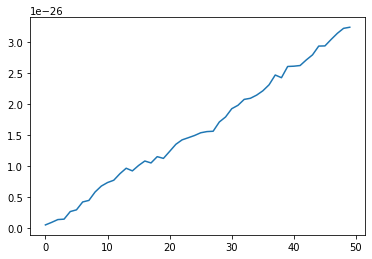

In [41]:
print(data)
plt.plot(time,data)